<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/detection_and_segmentation/Isolation_Forests_For_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isolation Forests For Anomaly Detection

In [ ]:
! pip install flyingcircus

     |████████████████████████████████| 182 kB 4.9 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 


In [ ]:
from random import random
from influxdb import InfluxDBClient
import operator
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import scipy as sp
from scipy.stats import entropy
from sklearn.ensemble import IsolationForest
import flyingcircus.extra as fc


client = InfluxDBClient("sensorweb.us", "8086", "test", "sensorweb", "shake", ssl=True)
unit = "b8:27:eb:16:1b:d7"


stampIni = "2020-08-14T17:22:15.000Z";
stampEnd = "2020-08-14T17:25:15.000Z";

query = 'SELECT "value" FROM Z WHERE ("location" = \''+unit+'\')  and time >= \''+stampIni+'\' and time <= \''+stampEnd+'\'   '

result = client.query(query)
points = list(result.get_points())

values =  map(operator.itemgetter('value'), points)
times  =  map(operator.itemgetter('time'),  points)

datat = list(values)
timet= list(times)
i=0
for temp in datat:
  datat[i]=temp/10000
  i+=1



/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [ ]:
def IFanomaly(window = 10,outliers_fraction = 0.05):
  length=len(datat)
  #window based TEO with 0 padding
  TEO=[]
  i=0
  while i < length:
      if i>0 and i<length-1:
          temp = datat[i]*datat[i] + datat[i+1]*datat[i-1]
          TEO.append(temp)
      else:
          TEO.append(0)
      i+=1

  #window based kurtosis
  datatest=np.array(datat[0:length])
  new_arr = fc.rolling_apply_nd(datatest, window, func=sp.stats.kurtosis)

  size=len(new_arr)

  while size<length:
    num = random.randint(0, size-1)
    new_arr=np.append(new_arr,new_arr[num])
    size+=1
  d = np.zeros((length,4),dtype=np.float64)
  i=0

  while i<length:
    d[i][0]=i
    d[i][1]=datat[i]
    d[i][2]=TEO[i]
    d[i][3] = new_arr[i]
    i+=1
  #  print(datat[i])

  df = pd.DataFrame(d, columns=['date_time_int','value','teo', 'kurt'])
  data = df[['value', 'teo', 'kurt']]
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(data)
  data = pd.DataFrame(np_scaled)

  # train isolation forest
  model =  IsolationForest(contamination=outliers_fraction)
  model.fit(data) 
  df['anomaly2'] = pd.Series(model.predict(data))
  return df


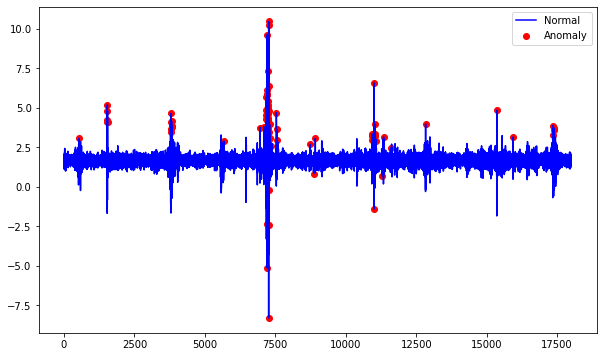

In [ ]:
outliers_fraction=0.005
window = 10
data = datat
df = IFanomaly(window,outliers_fraction)
# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly2'] == -1, ['date_time_int', 'value']] #anomaly

ax.plot(df['date_time_int'], df['value'], color='blue', label = 'Normal')
ax.scatter(a['date_time_int'],a['value'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

In [ ]:
!pip install adtk
import csv
import pywt
from influxdb import InfluxDBClient
import operator
import scipy.signal as sg
import scipy as sp
import sklearn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from adtk.data import validate_series
from adtk.visualization import plot

     |████████████████████████████████| 60 kB 3.3 MB/s 


In [ ]:
ip = "sensorweb.us" 
unit = "b8:27:eb:76:15:20" # FloorB
stampIni = "2020-07-07T19:18:14.000Z" # UTC time = EST time + 4
stampEnd = "2020-07-07T19:18:22.000Z"
client = InfluxDBClient(ip, "8086", "test", "sensorweb", "shake",ssl=True)
# Check FloorB at http://3.136.84.223:3000/d/3HdIpxGMz/s-house-dashboard-raw-data-only?orgId=1&from=1594149493945&to=1594149503005

query = 'SELECT "value" FROM Z WHERE ("location" = \''+unit+'\')  and time >= \''+stampIni+'\' and time <= \''+stampEnd+'\'   '
result = client.query(query)
points = list(result.get_points())
values =  map(operator.itemgetter('value'), points)
times  =  map(operator.itemgetter('time'),  points)
data = np.array(list(values))
times = np.array(list(times))
if(len(data) == 0):
  print("No data in the chosen time range!")
  quit()
index = pd.DatetimeIndex(times)
data = pd.Series(data,index=index)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


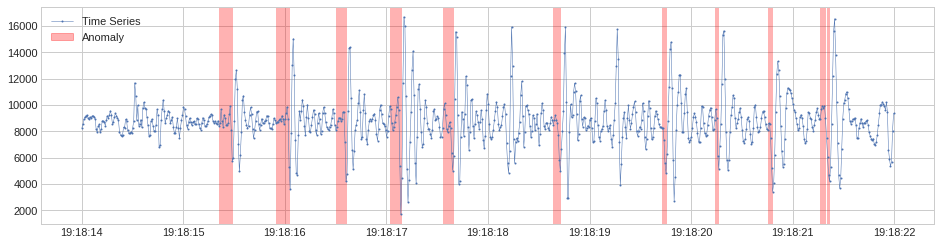

In [ ]:
volatility_shift_ad = VolatilityShiftAD(c=2.0, side='positive', window=15)
anomalies = volatility_shift_ad.fit_detect(data)
plot(data, anomaly=anomalies, anomaly_color='red');